In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 3218885689
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3218885689


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 500
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 140,
    #"to_freeze_gpt_blocks": 11,
    'warmup_factor': 1
}
config.update(optuna_result_attachement)

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    print("Pretrained model loaded")
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
else:
    print("Loaded empty model")
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
model.to(device)
# set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)

Loaded empty model


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, o

# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragonfly with an incredibly large, massive dragonfly, and I was very happy to see the world around me grow!

I've been growing dragonflies since I was a kid, and my dragonfly wings were a blast. I'm still a dragonfly in a lot of ways, and I think I've learned to fly a lot. I love the big, strong dragonfly wings and I think they're the most beautiful thing I've ever seen. I love the beautiful dragonfly wings! I've also had to learn how to fly my dragonfly wings a lot, and I love how


# Reviewing our dataset!

In [7]:
dataset = get_dataset(tokenizer)
print("Dataset demo snapshot:")
demo_idx = 0
for item in dataset['train']:
    print(tokenizer.decode(item['input_ids']))
    if demo_idx > 0:
        break
    demo_idx += 1

print("RP review!")
has_seen_rp = False
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    if 'c "Fight ' in decoded: 
        print(decoded)
        has_seen_rp = True
        continue        
    if has_seen_rp:
        print(decoded)
        break
        
del demo_idx, has_seen_rp

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset demo snapshot:


Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors


<p><msg>c "Essentially, a blemmyes is a human without a head."<|endoftext|><p><msg>c "Ugh, this is some really strong stuff."<|endoftext|><d><scn>loremapt<msg>Ip "Now, what happens when we approach the edge and walk over it is that we are teleported to the opposite side."<|endoftext|><d><scn>black<msg>n "She froze to death during the cold winter night."<|endoftext|><d><scn>park2<msg>Ry "To think that just a few years ago I was the
 happiest I could've been. And now, I have nothing but my miserable life."<|endoftext|><p><msg>c "You could try it if you like."<|endoftext|><d><scn>black<msg>m "It was a little bland, I had to admit, but not bad for something that was alive less than an hour ago, and prepared in the wild."<|endoftext|><p><msg>c "The bedroom here is nothing special, I can assure you of that."<|endoftext|><d><scn>cafe<msg>An "I still could have calculated that."<|endoftext|>soon" now refers to a time
RP review!


Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors


facin3<msg>Lo "Hey, [player_name]!"<|endoftext|><d><scn>park2<msg>Ry "There must be a lot on your mind too."<|endoftext|><d><scn>facin2<msg>m "Bryce nodded."<|endoftext|><p><msg>c "Like an animal."<|endoftext|><p><msg>c "Fight Remy"<d><scn>facin2<msg>m "I didn't hesitate and kicked Remy right in the stomach"<|endoftext|><d><scn>o2<msg>Ad "Well, go ahead, then
."<|endoftext|><p><msg>c "No fitting me in during your break, no complaining about everything, and no acting as if you're doing me a favor, especially because it was you who wanted to meet me in the first place."<|endoftext|><p><msg>c "..."<d><scn>o2<msg>Br "..."<|endoftext|><p><msg>c "I'll try."<|endoftext|><p><msg>c "(Well, here goes nothing.)"<|endoftext|><p><msg>c "Does this mean we get teleported to the other side, like in video games?"<d><sc


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [8]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

[0] set freeze_part_layers: True (freezing 140 out of 160 layers.)


Step,Training Loss
540,1.400700
1080,0.544100
1620,0.402900
2160,0.359100
2700,0.331500
3240,0.314900
3780,0.305000
4320,0.297500
4860,0.292500
5400,0.288400


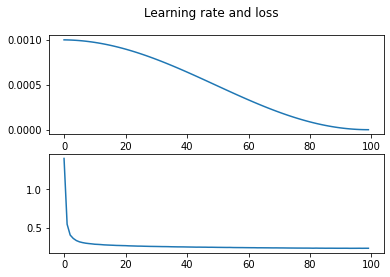

In [9]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.
The first test involves a old prompt to compare the pre-trained model with the one trained on AWSW. Did it manage to store it's data well? Is it able to write down things that have nothing to do with AWSW? (So we know we didn't overfit).

In [10]:
model.eval()
test_regular_sampler()

In my dreams, I'm a dragon."<d><scn>o2<msg>Ad "That's a hard one. I mean, no one would see my flying then, and I do want people to see that."<|endoftext|>


**This test generates boring and repetetive** replies! It's because we use no good sampling algorithm, but it does give us a indication of what the model has learned!

In [11]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: park2<msg>Ry "Th-the summer festival is coming soon. It's an event we hold in town every year."<d><scn>park2<msg>Ry "They've got fireworks and all kinds of shows."<d><scn>park2<msg>Ry "It might be fun for you to experience a different part of our culture."<d><scn>park2


Prompt: What do you think of Lorem?
Reply: park2<msg>Ry "I see."<p><msg>c "I was just asking a question, that's all."<d><scn>park2<msg>Ry "Well, what do you think of it?"<p><msg>c "It's pretty idyllic."<d><scn>park2<msg>Ry "


Prompt: Oh my god, Adine. What is this?
Reply: np1x<msg>Sb "It's broken."<|endoftext|>


Prompt: What will we do here?
Reply: facin2<msg>An "I don't know where you are going, but I think I need a coffee or five. You can tag along if you like."<p><msg>c "I think I'd rather not."<d><scn>facin2<msg>An "Suit yourself."<d><scn>facin2<msg>n "Whatever the reason, I decided not to join her




# Sampling test

This is gonna be interesting!

In [12]:
for i in range(10):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1] -> Prompt: How are you?
Reply: park2<msg>Ry "Th-the summer festival is coming soon. It's an event we hold in town every year."<d><scn>park2<msg>Ry "They've got fireworks and all kinds of shows."<d><scn>park2<msg>Ry "It might be fun for you to experience a different part of our culture."<d><scn>park2

[Test 1] -> Prompt: What do you think of Lorem?
Reply: park2<msg>Ry "I see."<p><msg>c "I'm with you on this."<p><msg>c "Okay, but why focus on humans? What makes us so important?"<d><scn>black<msg>Lo "If there’s one thing that people here love, it’s humans. It doesn

[Test 1] -> Prompt: Oh my god, Adine. What is this?
Reply: np1x<msg>Sb "It's broken."<|endoftext|>

[Test 1] -> Prompt: What will we do here?
Reply: facin2<msg>An "What are you looking at?"<p><msg>c "Your beautiful door. Where have you been all this time?"<|endoftext|>

-------------
[Test 2] -> Prompt: How are you?
Reply: park2<msg>Ry "Th-the summer festival is coming soon. It's an event we hold in town every year."<

# RP test
Testing out the injected roleplay actions

In [13]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]
for rp in test_rps:
    print(f'{rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')

Visit Lorem -> loremapt<msg>Lo "Oh, [player_name], I wasn't expecting visitors."<|endoftext|>
Meet with Lorem -> loremapt<msg>Lo "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
Visit Adine -> adineapt<msg>Ad "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
Fight Maverick -> park3<msg>m "Maverick barely avoids my attack and fell, but managed to get up and quickly punch me in the face, a soaring pain quickly came over my face"<|endoftext|>
Fight Adine -> o2<msg>m "Adine dodges my attack and comes rushing towards me"<|endoftext|>
Attack Adine -> beach<msg>m "Adine dodges my attack and comes rushing towards me"<|endoftext|>
